In [302]:
%matplotlib inline
import re
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import mca
from ast import literal_eval
from scipy.spatial.distance import cosine

http://www.gastonsanchez.com/visually-enforced/how-to/2012/10/13/MCA-in-R/  
https://pypi.org/project/mca/

In [2]:
datadir = '/Users/klarnemann/Documents/Insight/Insight_project/data'
figdir = '/Users/klarnemann/Documents/Insight/Insight_project/docs/figures'

In [208]:
wiki_museum_df_f = '%s/clean_scraped_wikipedia_tables_museums.csv' % (datadir)
wiki_museum_df = pd.read_csv(wiki_museum_df_f, index_col=0)

In [4]:
park_df_f = '%s/scraped_parks.xlsx' % (datadir)
park_df = pd.read_excel(park_df_f, index_col=0)

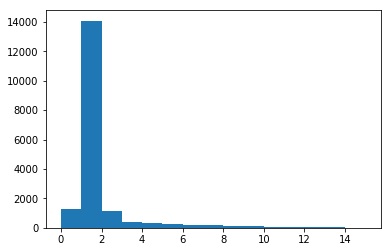

In [426]:
plt.hist(category_df.sum(axis=1), bins=np.arange(0,16));

In [5]:
print(wiki_museum_df.shape)
print(park_df.shape)

(14574, 13)
(3748, 11)


In [6]:
wiki_museum_df.head(2)

,Name,Location,Category,City,State,Article_content,Region,County,Summary,Notes,Article_tokens,General_category,dummy_value
0,Alabama Administrative Office of Courts Museum...,"Montgomery, Alabama",Law,Montgomery,Alabama,NaN,Central,Montgomery,Exhibits of Alabama judicial history and impor...,NaN,NaN,Government,1
1,Alabama Artists Gallery,"Montgomery, Alabama",Art,Montgomery,Alabama,"Fred Nall Hollis (born April 21, 1948) is an i...",Central,Montgomery,Operated by the Alabama State Council on the A...,NaN,"['fred', 'nall', 'hollis', 'born', 'april', 'i...",Art,1


In [7]:
park_df.head(2)

,Park,Location,State,City,Street Address,Url,Category,Features,Description,Article_content,Article_tokens
0,Bladon Springs State Park,"Silas, Alabama",Alabama,Silas,3921 Bladon Rd,https://www.stateparks.com/bladon_springs_stat...,State Park,"['Camping', 'Nearby Parks', 'Picnicking', 'Cur...","Centering around four mineral springs, this 3...",Bladon Springs State Park is a locally managed...,"['bladon', 'springs', 'state', 'park', 'is', '..."
1,Blue Springs State Park,"Clio, Alabama",Alabama,Clio,2595 AL-10,https://www.stateparks.com/blue_springs_state_...,State Park,"['Camping', 'Swimming', 'Fishing', 'Picnicking...","Fed by a crystal-clear underground spring, th...",Blue Spring State Park is a state park located...,"['blue', 'spring', 'state', 'park', 'is', 'a',..."


In [47]:
overlapping_cities = set.intersection(set(wiki_museum_df.Location), set(park_df.Location))
len(overlapping_cities)

926

In [48]:
all_cities = list(set.union(set(wiki_museum_df.Location), set(park_df.Location)))
len(all_cities)

8390

In [10]:
wiki_museum_df['General_category'].unique()

array(['Government', 'Art', 'Open air', 'History', 'Historic house',
       'Entertainment/Media', 'Industry', 'Technology', 'Natural history',
       'General', 'Sports', 'Military', 'Local history', 'Religious',
       'Transportation', 'Heritage', "Children's", 'Biography', 'Science',
       'Sport', 'Open-air', 'Public service', nan, 'Toy',
       'Anthropology/Archaeology', 'Commodity', 'Agriculture', 'Literary',
       'Nature center', 'Textile', 'Historic site', 'Obscure', 'Library',
       'Architecture', 'Aquarium', 'Zoo'], dtype=object)

In [11]:
wiki_museum_df.Category.unique()

array(['Law', 'Art', 'Living history', 'History', 'Historic house',
       'Radio', 'Music', 'Industry', 'Medical', 'Natural history',
       'Multiple', 'Sports', 'Capitol', 'Military', 'Mining',
       'Local history', 'Religious', 'Automotive',
       'History\xa0/ African\xa0American', 'Railroad', 'Decorative arts',
       'African\xa0American', "Children's", 'Biographical', 'Science',
       'Native\xa0American', 'Transportation',
       'Sports /History\xa0/ African\xa0American', 'Native American',
       'Open-air', 'Firefighting', 'website', 'Aviation', 'Aerospace',
       'Alaskan Native', 'Law enforcement', "Alaska's Military History",
       'Technology', 'Maritime', 'History - Local',
       'Ethnic - Native American', 'Toy', 'Scouting', 'Archaeology',
       'Hall of fame - Sports', 'Geology', 'History / Geology', 'Jewish',
       'American West', 'Prison', 'School', 'Anthropology', 'Automobile',
       'Doll', 'Military - United States', 'History - local',
       'Philate

In [12]:
len(wiki_museum_df['General_category'].unique())

36

In [13]:
len(wiki_museum_df.Category.unique())

471

# Analysis

## Museums: Dummy categories

In [446]:
#museum_categories.insert(33, 'All_categories', wiki_museum_df.General_multi_categories)

In [810]:
museum_categories.insert(1, 'Name', wiki_museum_df.Name[museum_categories.index])

In [679]:
tmp_s = wiki_museum_df.General_multi_categories
museum_categories = pd.get_dummies(tmp_s.apply(pd.Series).stack()).sum(level=0)

In [680]:
museum_categories.insert(0, 'Location', wiki_museum_df.Location[museum_categories.index])

In [681]:
museum_categories = museum_categories.drop('', axis=1)

In [682]:
museum_categories.shape

(14571, 26)

In [683]:
museum_cats = museum_categories.columns[1:]
print(len(museum_cats))
museum_cats

25


Index(['Agriculture', 'Anthropology/Archaeology', 'Art', 'Biography',
       'Children's', 'Commodity', 'Entertainment/Media', 'Heritage',
       'Historic house', 'Historic site', 'History', 'Industry', 'Literary',
       'Local history', 'Military', 'Natural history', 'Open air',
       'Public service', 'Religious', 'Science', 'Sport', 'Technology',
       'Textile', 'Transportation', 'Zoo/Aquarium'],
      dtype='object')

In [684]:
multi_museums_by_city = museum_categories.pivot_table(values=museum_cats, index=['Location'],\
                                            aggfunc=np.sum, fill_value=0.0)

In [685]:
multi_museums_by_city.shape

(7428, 25)

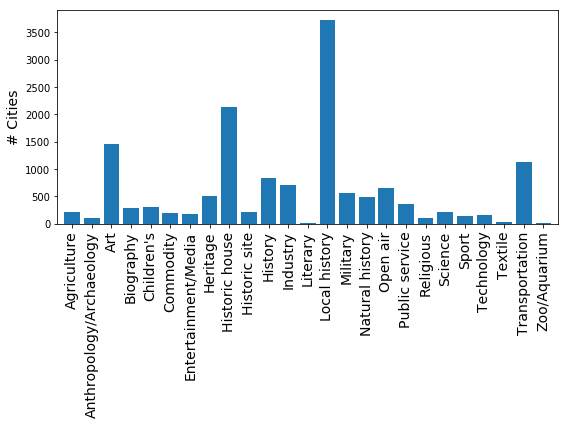

In [760]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(25), multi_museums_by_city.sum(axis=0));
plt.xticks(np.arange(25), multi_museums_by_city.columns, rotation=90, fontsize=14);
plt.xlim(-0.75,24.75);
plt.ylabel('# Cities', fontsize=14)
plt.tight_layout()
plt.savefig('%s/bar_number_cities_with_museum_category.png' % (figdir), dpi=150, transparent=True)

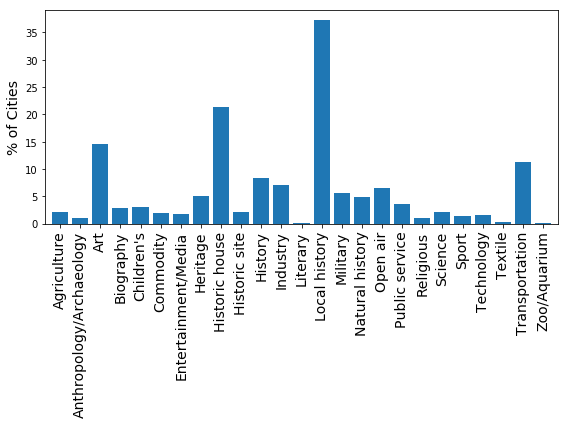

In [761]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(25), (multi_museums_by_city.sum(axis=0)/9983.)*100);
plt.xticks(np.arange(25), multi_museums_by_city.columns, rotation=90, fontsize=14);
plt.xlim(-0.75,24.75);
plt.ylabel('% of Cities', fontsize=14)
plt.tight_layout()
plt.savefig('%s/bar_percent_cities_with_museum_category.png' % (figdir), dpi=150, transparent=True)

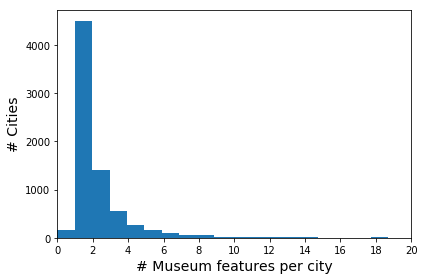

In [758]:
plt.figure(figsize=(6,4))
plt.hist(multi_museums_by_city.sum(axis=1), bins=60);
plt.xlim(0,20)
plt.xticks(np.linspace(0, 20, 11), np.linspace(0, 20, 11, dtype=int))
plt.xlabel('# Museum features per city', fontsize=14)
plt.ylabel('# Cities', fontsize=14)
plt.tight_layout()
plt.savefig('%s/hist_n_museum_in_cities.png' % (figdir), dpi=150, transparent=True)

## Parks: Dummy categories

In [28]:
park_df_f = '%s/scraped_parks.xlsx' % (datadir)
park_df = pd.read_excel(park_df_f, index_col=0)

In [29]:
park_df.Features[pd.isna(park_df.Features)] = ['None']

In [30]:
park_df.Features = park_df.Features.apply(literal_eval)

In [31]:
tmp_s = park_df['Features']
park_categories = pd.get_dummies(tmp_s.apply(pd.Series).stack()).sum(level=0)

In [32]:
park_categories = park_categories.drop(['Current Weather Prediction', 'Day Use Area', \
                                        'Directions', 'Meeting Rooms', 'Nearby Parks', \
                                        'Park Store', 'Passes', 'Pets', \
                                        'Places To Find Supplies', 'Rules', \
                                        'Explore the Wonders of Talimena State Park', \
                                        'Great Smoky Mountains National Park', \
                                        'Visiting Voyageurs National Park'], axis=1)

In [33]:
park_categories['Cabins'] = park_categories[['Area Cabins and Lodges', 'Cabins']].sum(axis=1)

In [34]:
park_categories['Lodge'] = park_categories[['Area Cabins and Lodges', 'Lodge']].sum(axis=1)

In [35]:
park_categories.insert(3, 'Attractions', park_categories[['Area Attractions', \
                      'Things To Do in the Area']].sum(axis=1))

In [36]:
park_categories['Camping'] = park_categories[['Area Campgrounds', \
                                              'Camping']].sum(axis=1)

In [37]:
park_categories['Fishing'] = park_categories[['Area Fishing Related Businesses', \
                                              'Fishing']].sum(axis=1)

In [38]:
park_categories['Boating'] = park_categories[['Boats and RVs', \
                                              'Boating']].sum(axis=1)

In [39]:
park_categories = park_categories.drop(['Boats and RVs', 'Area Fishing Related Businesses', \
                                        'Area Campgrounds', 'Area Cabins and Lodges', \
                                        'Area Attractions', 'Things To Do in the Area'], axis=1)

In [40]:
print(len(park_categories.columns))
park_categories.columns

30


Index(['Airport', 'Attractions', 'Area Resources', 'Area Shopping', 'Beaches',
       'Bicycling', 'Birding', 'Boating', 'Cabins', 'Camping', 'Canoeing',
       'Cottages', 'Cross-country Skiing', 'Fishing', 'Geocaching',
       'Golf Course', 'History of the Area', 'Lodge', 'Marinas',
       'Nature Programs', 'Nature of the Area', 'Nearby Accommodations',
       'Picnicking', 'Rock Climbing and Rappelling', 'Scuba Diving',
       'Snorkeling', 'Surfing', 'Swimming', 'Trails', 'Visitors Center'],
      dtype='object')

In [ ]:
park_categories.insert(0, 'Name', park_df.Park)
park_categories.insert(1, 'Location', park_df.Location)

In [42]:
park_cats = list(park_categories.columns[2:])

In [850]:
park_categories = park_categories.drop_duplicates()

In [ ]:
park_categories.shape

## Pivot table: Park features by city

In [447]:
park_categories.insert(33, 'All_categories', park_df.Category)

In [44]:
park_categories['dummy_value'] = 1

In [45]:
parks_by_city = park_categories.pivot_table(values=park_cats, index=['Location'],\
                                            aggfunc=np.sum, fill_value=0.0)

In [46]:
parks_by_city

,Airport,Area Resources,Area Shopping,Attractions,Beaches,Bicycling,Birding,Boating,Cabins,Camping,...,Nature of the Area,Nearby Accommodations,Picnicking,Rock Climbing and Rappelling,Scuba Diving,Snorkeling,Surfing,Swimming,Trails,Visitors Center
Location,,,,,,,,,,,,,,,,,,,,,
"Abbeville, Louisiana",0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
"Abington, Massachusetts",0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
"Ackerman, Mississippi",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Adams, Tennessee",0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
"Adel, Georgia",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
"Agawam, Massachusetts",0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
"Ajo, Arizona",0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
"Akron, Ohio",0,0,0,1,0,0,0,1,1,2,...,1,0,1,0,0,0,0,1,1,0
"Alachua, Florida",0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


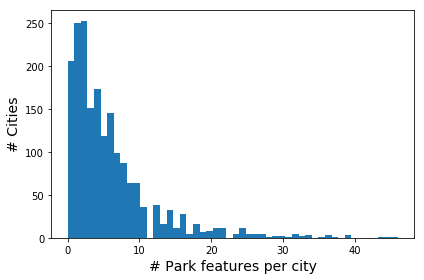

In [763]:
plt.figure(figsize=(6,4))
plt.hist(parks_by_city.sum(axis=1), bins=50);
#plt.xlim(0,17)
plt.xlabel('# Park features per city', fontsize=14)
plt.ylabel('# Cities', fontsize=14)
plt.tight_layout()
plt.savefig('%s/hist_n_park_in_cities.png' % (figdir), dpi=150, transparent=True)

## Combine park and museum dfs

In [47]:
overlapping_cities = set.intersection(set(wiki_museum_df.Location), set(park_df.Location))
len(overlapping_cities)

926

In [48]:
all_cities = list(set.union(set(wiki_museum_df.Location), set(park_df.Location)))
len(all_cities)

8390

In [457]:
all_cities = all_cities[1:]

In [ ]:
all_cities.remove('Redmond, Oregon')

In [695]:
#poi_by_city = multi_museums_by_city.merge(parks_by_city, on='Location', how='outer')

In [696]:
poi_by_city = poi_by_city.fillna(0.)

In [854]:
city_pois = []
for i, city in enumerate(poi_by_city.index):
    if i % 1000 == 0:
        print(i)
    mask = category_df.Location == city
    pois = list(category_df.Name.loc[mask])
    city_pois.append(pois)

0
1000
2000
3000
4000
5000
6000


KeyboardInterrupt: 

In [828]:
poi_by_city['POI_names'] = city_pois

In [832]:
city_cats = []
all_cats = np.array(poi_by_city.columns[2:])
for i, city in enumerate(poi_by_city.index):
    if i % 1000 == 0:
        print(i)
    col_mask = np.array(poi_by_city[all_cats].iloc[i] > 0.)
    cats = list(all_cats[col_mask])
    city_cats.append(cats)

0
1000
2000
3000
4000
5000
6000
7000
8000


In [843]:
poi_by_city.insert(1, 'All_categories', city_cats)

,POI_names,All_categories,All_cateogires,Agriculture,Anthropology/Archaeology,Art,Biography,Children's,Commodity,Entertainment/Media,...,Nature of the Area,Nearby Accommodations,Picnicking,Rock Climbing and Rappelling,Scuba Diving,Snorkeling,Surfing,Swimming,Trails,Visitors Center
Location,,,,,,,,,,,,,,,,,,,,,
"Aaronsburg, Pennsylvania",[Penns Valley Area Historical Museum],[Local history],[Local history],0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Abbeville, Louisiana","[Abbeville Museum, Louisiana Military Hall of ...","[History, Military, Camping]","[History, Military, Camping]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Abbeville, South Carolina",[Burt-Stark Mansion],[Historic house],[Historic house],0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Abbot, Maine",[Abbot Historical Society Museum],[Local history],[Local history],0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Abercrombie, North Dakota",[Fort Abercrombie State Historic Site],[Military],[Military],0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Aberdeen, Maryland",[Aberdeen Room Archives & Museum],[Local history],[Local history],0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Aberdeen, Mississippi","[Holliday Haven, The Magnolias (Aberdeen, Miss...",[Historic house],[Historic house],0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Aberdeen, South Dakota",[Dacotah Prairie Museum],[],[],0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Aberdeen, Washington",[Aberdeen Museum of History],[Local history],[Local history],0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


~~~
tmp_cols = ['POI_names'] + list(poi_by_city.columns[:-1])
poi_by_city = poi_by_city[tmp_cols]
poi_by_city.columns
~~~

In [703]:
poi_by_city.shape

(8388, 57)

(0, 20)

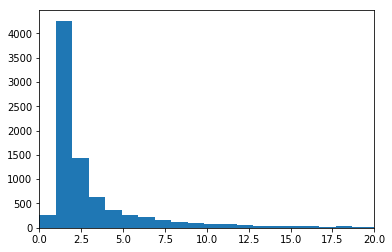

In [707]:
plt.hist(poi_by_city.sum(axis=1), bins=60)
plt.xlim(0,20)

In [846]:
poi_by_city.to_excel('%s/poi_by_city_museums_and_parks.xlsx' % (datadir))

In [871]:
category_df = pd.concat([museum_categories, park_categories])
category_df = category_df.fillna(0.)
category_df = category_df.drop('dummy_value', axis=1)
category_df = category_df.drop('All_categories', axis=1)
print(category_df.shape)

(17631, 57)


/Users/klarnemann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [872]:
tmp = list(category_df.columns)
tmp.remove('Name')
tmp.remove('Location')
category_cols = ['Name', 'Location'] + tmp
category_df = category_df[category_cols]

In [873]:
category_df.columns[2:]

Index(['Agriculture', 'Airport', 'Anthropology/Archaeology', 'Area Resources',
       'Area Shopping', 'Art', 'Attractions', 'Beaches', 'Bicycling',
       'Biography', 'Birding', 'Boating', 'Cabins', 'Camping', 'Canoeing',
       'Children's', 'Commodity', 'Cottages', 'Cross-country Skiing',
       'Entertainment/Media', 'Fishing', 'Geocaching', 'Golf Course',
       'Heritage', 'Historic house', 'Historic site', 'History',
       'History of the Area', 'Industry', 'Literary', 'Local history', 'Lodge',
       'Marinas', 'Military', 'Natural history', 'Nature Programs',
       'Nature of the Area', 'Nearby Accommodations', 'Open air', 'Picnicking',
       'Public service', 'Religious', 'Rock Climbing and Rappelling',
       'Science', 'Scuba Diving', 'Snorkeling', 'Sport', 'Surfing', 'Swimming',
       'Technology', 'Textile', 'Trails', 'Transportation', 'Visitors Center',
       'Zoo/Aquarium'],
      dtype='object')

In [874]:
poi_cats = []
all_cats = np.array(category_df.columns[2:])
for i, poi in enumerate(category_df.index):
    if i % 1000 == 0:
        print(i)
    col_mask = np.array(category_df[all_cats].iloc[i] > 0.)
    cats = list(all_cats[col_mask])
    poi_cats.append(cats)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


In [875]:
category_df.insert(2, 'All_categories', poi_cats)

In [876]:
category_df.head(3)

,Name,Location,All_categories,Agriculture,Airport,Anthropology/Archaeology,Area Resources,Area Shopping,Art,Attractions,...,Snorkeling,Sport,Surfing,Swimming,Technology,Textile,Trails,Transportation,Visitors Center,Zoo/Aquarium
0,Alabama Administrative Office of Courts Museum...,"Montgomery, Alabama","[Industry, Public service]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alabama Artists Gallery,"Montgomery, Alabama",[Art],0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alabama Constitution Village,"Huntsville, Alabama","[History, Open air]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [877]:
category_df.to_excel('%s/poi_museums_and_parks.xlsx' % (datadir))

## Cosine distance

In [322]:
def compute_pairwise_cosine_distance(data):
    n_cities, _ = data.shape
    out_mat = np.zeros(shape=(n_cities, n_cities))
    for i in np.arange(n_cities):
        if i % 200 == 0:
            print(i)
        for j in np.arange(n_cities):
            if i < j:
                out_mat[i,j] = cosine(data[i,:], data[j,:])
    return out_mat

In [323]:
np.array(poi_by_city).shape

(8388, 61)

In [324]:
cosine_mat = compute_pairwise_cosine_distance(np.array(poi_by_city))

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200


In [325]:
cosine_mat = cosine_mat + cosine_mat.T

~~~
cosine_g = nx.from_numpy_matrix(np.matrix(cosine_mat))
~~~

~~~
cosine_communities_set =  list(nx.algorithms.community.greedy_modularity_communities(cosine_g))
cosine_communities = [list(c) for c in cosine_communities_set]
~~~

~~~
for i, c in enumerate(cosine_communities_set):
    print(i, len(c))
~~~

~~~
cosine_reorder = [item for sublist in cosine_communities for item in sublist]
~~~

~~~
cosine_mat = np.array(cosine_mat)[reorder, :]
cosine_mat = cosine_mat[:, reorder]
~~~

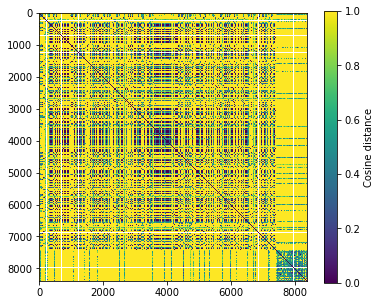

In [335]:
plt.figure(figsize=(6,5))
plt.imshow(cosine_mat, interpolation='nearest', cmap='viridis', clim=(0,1))
cbar = plt.colorbar()
cbar.set_label('Cosine distance')
plt.savefig('%s/cosine_distance_matrix_poi_by_city.png' % (figdir), dpi=150, transparent=True)

## Pairwise overlap

In [537]:
def compute_pairwise_overlap(df, cols):
    n_cities, _ = df.shape
    data = np.array(df[cols])
    out_mat = np.zeros(shape=(n_cities, n_cities))
    for i in np.arange(n_cities):
        for j in np.arange(n_cities):
            if i < j:
                row_1 = data[i,:] > 0
                row_2 = data[j,:] > 0
                mask = row_1 * row_2
                out_mat[i,j] = mask.sum()
    return out_mat

In [736]:
overlap_mat = compute_pairwise_overlap(poi_by_city, all_cats)
overlap_mat = overlap_mat + overlap_mat.T

In [737]:
overlap_df = pd.DataFrame(overlap_mat, index=poi_by_city.index, columns=poi_by_city.index)
overlap_df.head()

Location,"Aaronsburg, Pennsylvania","Abbeville, Louisiana","Abbeville, South Carolina","Abbot, Maine","Abercrombie, North Dakota","Aberdeen, Maryland","Aberdeen, Mississippi","Aberdeen, South Dakota","Aberdeen, Washington","Abilene, Kansas",...,"Woodville, Alabama","Worley, Idaho","Yazoo City MS, Mississippi","Yellow Springs, Ohio","Yreka, California","Yuma, California","Zahl, North Dakota","Zaleski, Ohio","Zimmerman, Minnesota","Zwolle, Louisiana"
Location,,,,,,,,,,,,,,,,,,,,,
"Aaronsburg, Pennsylvania",0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Abbeville, Louisiana",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
"Abbeville, South Carolina",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Abbot, Maine",1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Abercrombie, North Dakota",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [740]:
overlap_df.to_excel('%s/overlap_poi_categories_by_city.xlsx' % (datadir))

In [741]:
n_poi_by_city = np.array(poi_by_city.sum(axis=1))

In [742]:
n_poi_by_city = np.array(poi_by_city.sum(axis=1))
n_poi_by_city.shape

(8388,)

In [743]:
norm_overlap_mat = np.zeros(shape=(n_cities, n_cities))
for i in np.arange(n_cities):
    val = n_poi_by_city[i]
    norm_overlap_mat[:,i] = overlap_mat[:,i]/float(val)

/Users/klarnemann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [744]:
norm_overlap_mat[np.isnan(norm_overlap_mat)] = 0
norm_overlap_mat[np.isinf(norm_overlap_mat)] = 0

In [745]:
norm_overlap_df = pd.DataFrame(norm_overlap_mat, index=poi_by_city.index, columns=poi_by_city.index)
norm_overlap_df.head()

Location,"Aaronsburg, Pennsylvania","Abbeville, Louisiana","Abbeville, South Carolina","Abbot, Maine","Abercrombie, North Dakota","Aberdeen, Maryland","Aberdeen, Mississippi","Aberdeen, South Dakota","Aberdeen, Washington","Abilene, Kansas",...,"Woodville, Alabama","Worley, Idaho","Yazoo City MS, Mississippi","Yellow Springs, Ohio","Yreka, California","Yuma, California","Zahl, North Dakota","Zaleski, Ohio","Zimmerman, Minnesota","Zwolle, Louisiana"
Location,,,,,,,,,,,,,,,,,,,,,
"Aaronsburg, Pennsylvania",0.0,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
"Abbeville, Louisiana",0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.166667,...,0.333333,0.0,0.0,0.076923,0.0,0.0,0.0,0.333333,0.0,0.166667
"Abbeville, South Carolina",0.0,0.000000,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.166667,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
"Abbot, Maine",1.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
"Abercrombie, North Dakota",0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000


In [746]:
norm_overlap_df.to_excel('%s/norm_overlap_poi_categories_by_city.xlsx' % (datadir))

In [747]:
overlap_g = nx.from_numpy_matrix(np.matrix(overlap_mat))

In [748]:
communities_set = list(nx.algorithms.community.greedy_modularity_communities(overlap_g))
communities = [list(c) for c in communities_set]

In [749]:
for i, c in enumerate(communities_set):
    print(i, len(c))

0 4526
1 2483
2 1117
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1
100 1
101 1
102 1
103 1
104 1
105 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 1
118 1
119 1
120 1
121 1
122 1
123 1
124 1
125 1
126 1
127 1
128 1
129 1
130 1
131 1
132 1
133 1
134 1
135 1
136 1
137 1
138 1
139 1
140 1
141 1
142 1
143 1
144 1
145 1
146 1
147 1
148 1
149 1
150 1
151 1
152 1
153 1
154 1
155 1
156 1
157 1
158 1
159 1
160 1
161 1
162 1
163 1
164 1
165 1
166 1
167 1
168 1
169 1
170 1
171 1
172 1
173 1
174 1
175 1
176 1
177 1
178 1
179 1
180 1
181 1
182 1
183

In [750]:
print(len(communities_set[0]))
print(len(communities_set[1]))

4526
2483


In [751]:
reorder = [item for sublist in communities for item in sublist]

In [752]:
overlap_mat = overlap_mat + overlap_mat.T
overlap_mat = np.array(overlap_mat)[reorder, :]
overlap_mat = overlap_mat[:, reorder]

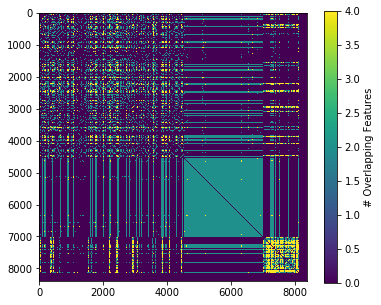

In [755]:
plt.figure(figsize=(6,5))
plt.imshow(overlap_mat, interpolation='nearest', cmap='viridis', clim=(0,4))
cbar = plt.colorbar()
cbar.set_label('# Overlapping Features')
plt.savefig('%s/overlap_matrix_poi_by_city.png' % (figdir), dpi=150, transparent=True)

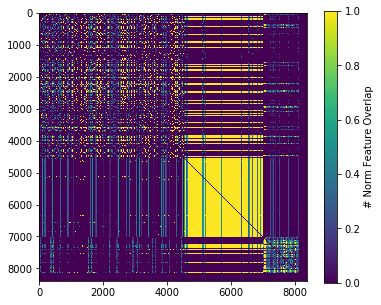

In [757]:
plt.figure(figsize=(6,5))
norm_overlap_mat = np.array(norm_overlap_mat)[reorder, :]
norm_overlap_mat = norm_overlap_mat[:, reorder]
plt.imshow(norm_overlap_mat, interpolation='nearest', cmap='viridis', clim=(0,1))
cbar = plt.colorbar()
cbar.set_label('# Norm Feature Overlap')
plt.savefig('%s/norm_overlap_matrix_poi_by_city.png' % (figdir), dpi=150, transparent=True)

## Multiple correspondence analysis

In [291]:
print(mca.MCA.__doc__)

Run MCA on selected columns of a pd DataFrame.
	
	If the column are specified, assume that they hold
	categorical variables that need to be replaced with
	dummy indicators, otherwise process the DataFrame as is.

	'cols': The columns of the DataFrame to process.
	'ncols': The number of columns before dummy coding. To be passed if cols isn't.
	'benzecri': Perform Benzécri correction (default: True)
	'TOL': value below which to round eigenvalues to zero (default: 1e-4)
	


In [788]:
mca_ben = mca.MCA(poi_by_city[poi_by_city.columns[2:]])
#mca_ind = mca.MCA(poi_by_city, benzecri=False)

In [789]:
expl_var_by_row = mca_ben.expl_var()

In [790]:
n_factors= len(expl_var_by_row)

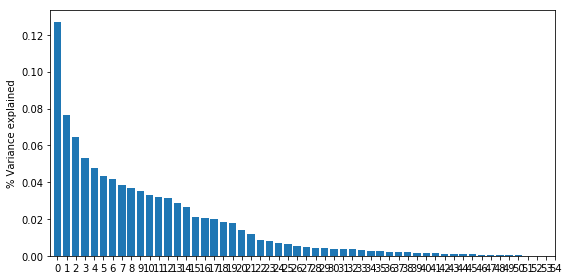

In [791]:
plt.figure(figsize=(8,4))
plt.bar(np.arange(n_factors), expl_var_by_row);
plt.xlim(-0.75, 34.75)
plt.xticks(np.arange(n_factors), np.arange(n_factors));
plt.ylabel('% Variance explained');
plt.tight_layout()

In [808]:
for i, col in enumerate(poi_by_city.columns[2:]):
    tmp_data = list(fs_cols[i,:])
    max_val = np.max(tmp_data)
    max_col_1 = tmp_data.index(max_val)
    tmp_data[max_col_1] = 0
    max_val = np.max(tmp_data)
    max_col_2 = tmp_data.index(max_val)
    print(col, max_col_1, max_col_2)

Agriculture 2 4
Anthropology/Archaeology 14 7
Art 19 16
Biography 11 8
Children's 13 8
Commodity 13 14
Entertainment/Media 16 17
Heritage 12 8
Historic house 9 17
Historic site 8 11
History 5 6
Industry 4 3
Literary 19 16
Local history 1 2
Military 9 8
Natural history 8 7
Open air 2 3
Public service 10 11
Religious 6 7
Science 21 19
Sport 11 15
Technology 16 18
Textile 15 17
Transportation 4 21
Zoo/Aquarium 8 19
Airport 0 10
Area Resources 0 20
Area Shopping 0 20
Attractions 0 1
Beaches 0 19
Bicycling 0 19
Birding 0 20
Boating 0 1
Cabins 0 20
Camping 0 1
Canoeing 0 19
Cottages 0 20
Cross-country Skiing 0 11
Fishing 0 20
Geocaching 0 4
Golf Course 20 0
History of the Area 0 1
Lodge 0 20
Marinas 0 20
Nature Programs 0 11
Nature of the Area 0 17
Nearby Accommodations 0 20
Picnicking 0 1
Rock Climbing and Rappelling 0 17
Scuba Diving 0 21
Snorkeling 0 19
Surfing 0 6
Swimming 0 1
Trails 0 1
Visitors Center 0 4


In [800]:
fs_cols = mca_ben.fs_c()
print(fs_cols.shape)
pd.DataFrame(fs_cols, index=poi_by_city.columns[2:])

(55, 22)


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
Agriculture,-0.656333,-0.180281,0.727145,-5.629536,0.500010,-0.023759,0.079085,-0.232917,0.217578,-0.048442,...,0.229890,-0.048705,0.016935,0.012358,-0.018672,-0.000722,-0.017580,0.008329,0.002816,-0.014922
Anthropology/Archaeology,-0.488388,-0.308334,-0.225417,-0.252598,-0.660376,-0.464752,-0.357892,1.555825,1.097329,-0.980211,...,-3.684835,-2.363970,3.602621,0.145475,-0.021172,-0.134149,0.071080,-0.168094,0.069332,0.105124
Art,-0.655897,-0.416217,-0.266929,0.031133,-0.160832,-0.000174,-0.043975,0.299325,0.266814,-0.051725,...,-0.221872,0.115940,-0.300983,0.174921,0.301167,-0.348949,-0.232128,0.798408,0.040122,-0.376088
Biography,-0.715686,-0.428778,-0.346184,0.123053,-0.032474,0.104260,0.072663,0.661325,0.948968,0.414840,...,0.751764,-0.692121,0.730357,-0.139014,-0.483416,0.551820,0.859906,0.436032,-0.022887,0.039157
Children's,-0.682296,-0.419264,-0.274290,0.005494,0.047464,0.014645,0.017858,0.200949,0.318581,0.026531,...,-0.463189,1.326961,0.243500,0.043135,-0.160703,-0.057466,0.154839,0.173426,-0.029633,-0.046576
Commodity,-0.779039,-0.335059,-0.298244,-0.026911,0.104290,0.078629,0.046130,0.203012,0.472712,0.062173,...,-0.995144,3.460307,1.022133,-0.118206,-0.773404,0.467362,0.200961,-0.395088,0.058971,0.045192
Entertainment/Media,-0.689623,-0.489192,-0.342782,0.041180,-0.131122,-0.036377,-0.042845,0.531227,0.516254,-0.014677,...,-0.002092,0.037982,0.104018,-0.782476,1.450206,1.381247,-2.609209,-1.035290,0.023933,-0.160755
Heritage,-0.648797,-0.352087,-0.375586,0.161151,-0.382411,-0.081096,-0.456349,0.910370,1.271469,-0.788522,...,1.710501,0.010059,0.312104,0.024974,-0.242292,0.154784,0.052602,-0.184782,-0.018788,0.010822
Historic house,-0.697039,-0.385857,-0.441297,-0.049656,-0.567972,-0.493690,-0.641872,-0.034171,-0.812125,0.109430,...,0.010384,-0.065278,0.024654,-0.014933,-0.116579,0.050986,0.047416,-0.105346,-0.013366,0.025729
Historic site,-0.520926,-0.283733,-0.294558,0.276950,-0.493756,-1.748562,-0.321273,-3.524666,1.410825,-1.789784,...,-0.079679,-0.108001,-0.015432,0.041004,-0.104298,-0.059662,-0.061611,-0.007591,0.033311,-0.080649


In [793]:
fs_rows = mca_ben.fs_r()
fs_rows.shape

(8388, 22)

In [794]:
pd.DataFrame(fs_rows).max(axis=0)

0      1.212543
1      1.647843
2      4.062996
3      0.607315
4      2.772907
5      2.869778
6      8.895836
7      2.313632
8      2.114184
9      3.587691
10     3.780345
11     3.262318
12     2.671751
13     5.513783
14     5.841676
15    17.817785
16     5.429340
17     6.332952
18     3.852685
19     1.427840
20     1.554265
21     2.854477
dtype: float64

In [795]:
fs_cosine_mat = compute_pairwise_cosine_distance(np.array(fs_rows))

0


/Users/klarnemann/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:702: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200


In [796]:
fs_cosine_mat = fs_cosine_mat + fs_cosine_mat.T

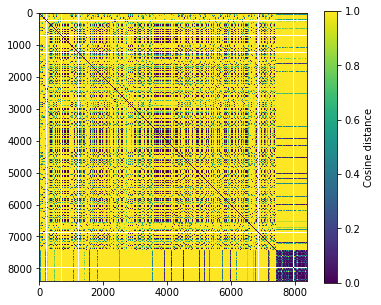

In [797]:
plt.figure(figsize=(6,5))
plt.imshow(fs_cosine_mat, interpolation='nearest', cmap='viridis', clim=(0,1))
cbar = plt.colorbar()
cbar.set_label('Cosine distance')
plt.savefig('%s/fs_cosine_distance_matrix_poi_by_city.png' % (figdir), dpi=150, transparent=True)

# Clean Data

## Hand-label museum categories

In [671]:
multi_categories = np.array([
['Law', ['Public service', 'Industry']],
['Living history', ['Open air', 'History']],
['Radio', 'Entertainment/Media'],
['Architecture', 'Art'],
['Music', 'Entertainment/Media'],
['Medical', 'Technology'],
['Capitol', 'Public service'],
['Mining', 'Industry'],
['Automotive', 'Transportation'],
['History / African American', ['Heritage', 'History']],
['Railroad', ['Transportation','Industry']],
['Decorative arts', 'Art'],
['African American', 'Heritage'],
['Biographical', 'Biography'],
['Native American', 'Heritage'],
['Sports /History / African American', ['Sport', 'Heritage']],
['Native American', 'Heritage'],
['Firefighting', 'Public service'],
['website', ''],
['Aviation', 'Transportation'],
['Aerospace', ['Science', 'Transportation']],
['Alaskan Native', 'Heritage'],
['Law enforcement', 'Public service'],
['Alaska\'s Military History', ['Military', 'Heritage']],
['Maritime', 'Transportation'],
['History - Local', 'Local history'],
['Ethnic - Native American', 'Heritage'],
['Scouting', 'Children\'s'],
['Archaeology', 'Anthropology/Archaeology'],
['Hall of fame - Sports', ['Sport', 'Biography']],
['Geology', 'Natural history'],
['History / Geology', ['Natural history', 'History']],
['Jewish', 'Heritage'],
['American West', 'Local history'],
['Prison', 'Public service'],
['School', 'Public service'],
['Anthropology', 'Anthropology/Archaeology'],
['Automobile', 'Transportation'],
['Doll', ['Commodity', 'Children\'s']],
['Military - United States', 'Military'],
['History - local', 'Local history'],
['Philatelic', 'Commodity'],
['Farm', 'Agriculture'],
['Art/History', ['Art', 'History']],
['Hall of fame - Entertainers', ['Entertainment/Media', 'Biography']],
['Industry - Wine making', 'Industry'],
['Industry - Petroleum', 'Industry'],
['Historic house - Biographical', ['Historic house', 'Biography']],
['Geology - Gems', 'Natural history'],
['Commodity - Airguns', 'Commodity'],
['African American', 'Heritage'],
['Fashion', 'Commodity'],
['Railroad - Trolley', ['Transportation', 'Industry']],
['Media', 'Entertainment/Media'],
['Historic house - History', 'Historic house'],
['Ethnic', 'Heritage'],
['Wax museum', 'Entertainment/Media'],
['Civil War', 'Military'],
['Automobile racing - Biography', ['Transportation', 'Biography']],
['Ethnic - African American', 'Heritage'],
['Transportation - Automobiles', 'Transportation'],
['Military - Civil War', 'Military'],
['Children\'s, science', ['Children\'s', 'Science']],
['Archaeology - Native American', ['Anthropology/Archaeology', 'Heritage']],
['Historic store', 'Historic house'],
['Mill', 'Historic site'],
['Local History', 'Local history'],
['Ethnic - Chinese', 'Heritage'],
['Living', 'Open air'],
['Design', 'Entertainment/Media'],
['Numismatic', 'Commodity'],
['History Museum', 'History'],
['Railway', ['Transportation', 'Industry']],
['Children', 'Children\'s'],
['Natural History', 'Natural history'],
['Veterans', 'Military'],
['Telecommunicatios', 'Technology'],
['Education', 'Public service'],
['Space and Science', 'Science'],
['Historic building', 'Historic site'],
['Local', 'Local history'],
['Horology', 'Agriculture'],
['Puppetry', ['Commodity', 'Entertainment/Media']],
['Farming', 'Agriculture'],
['Craft', 'Industry'],
['Natural', 'Natural history'],
['Hall of fame - sports', ['Sport', 'Biography']],
['Industry - glass', 'Industry'],
['Ethnic - Jewish', 'Heritage'],
['Jail museum', 'Public service'],
['Historic tavern', 'Historic site'],
['Historic artist\'s studio', 'Historic site'],
['Lighthouse', 'Historic site'],
['History / Commodity - tools', ['Commodity', 'History', 'Technology']],
['Community art', 'Art'],
['History / Natural history', ['Natural history', 'History']],
['Mansion', 'Historic site'],
['Historic houses', 'Historic house'],
['Haitian art', ['Art', 'Heritage']],
['Ethnic-Native American', 'Heritage'],
['Ethnic-African American', 'Heritage'],
['Multi', ''],
['Ethnic-Jewish', 'Heritage'],
['Industrial', 'Industry'],
['Historic House', 'Historic house'],
['Ethnic-Haitian', 'Heritage'],
['History & Science', ['History', 'Science']],
['Ethnic-African-American', 'Heritage'],
['Ethnic-Japanese', 'Heritage'],
['Cinema', 'Entertainment/Media'],
['Photography', 'Art'],
['Government', 'Public service'],
['Local & Natural History', ['Local history', 'Natural history']],
['Miscellaneous', ''],
['Wax', 'Entertainment/Media'],
['Knives', 'Commodity'],
['Ethnic-Cuban', 'Heritage'],
['History / African American', ['Heritage', 'History']],
['Archaeological', 'Anthropology/Archaeology'],
['Industry - Cotton', 'Industry'],
['Science and history', ['History', 'Science']],
['Car Museum', 'Transportation'],
['Automotive Museum', 'Transportation'],
['Culture', 'Heritage'],
['Oddities', 'Commodity'],
['Natural history/Science', ['Science', 'Natural history']],
['Food', 'Commodity'],
['US Military', 'Military'],
['Astronomy', 'Science'],
['Ethnic - Basque-American', 'Heritage'],
['Toy / collectibles', ['Commodity', 'Children\'s']],
['Industry - mining', 'Industry'],
['Industry - mining / science - geology', ['Industry', 'Science', 'Natural history']],
['Food - Potato', ['Commodity', 'Agriculture']],
['Industry - Timber', 'Industry'],
['Industry - prostitution', 'Industry'],
['Biography', 'Biography'],
['Ethnic - Native American / geology', ['Heritage', 'Natural history']],
['Entertainment', 'Entertainment/Media'],
['Decorative art', 'Art'],
['Cultural', 'Heritage'],
['Archeology', 'Anthropology/Archaeology'],
['African-American', 'Heritage'],
['Institutional Educational History', ['Public service', 'History']],
['Sex', 'Industry'],
['Other', ''],
['Art, Science & Humanities', ['Art', 'Science']],
['Arcade', ['Entertainment/Media', 'Commodity']],
['Circus', ['Entertainment/Media', 'Open air']],
['Glass', 'Industry'],
['Museum', ''],
['Jail', 'Public service'],
['Autombile', 'Transportation'],
['Tractor', 'Agriculture'],
['Aviation & Transportation', 'Transportation'],
['Forestry', 'Industry'],
['Theatre', 'Entertainment/Media'],
['Amusement', ''],
['Unsung Hero History', 'History'],
['Fort', ['Historic site', 'Military']],
['Puppet', 'Commodity'],
['Historical house', 'Historic house'],
['Brand History', 'Commodity'],
['Religion', 'Religious'],
['Collectibles', 'Commodity'],
['Historical society', 'History'],
['Fire', 'Industry'],
['Collectible', 'Commodity'],
['Anthropological', 'Anthropology/Archaeology'],
['Transportation - Canal', 'Transportation'],
['Blacksmith', 'Industry'],
['County history, genealogy resources', 'Local history'],
['Regional Jewish History', 'Heritage'],
['State capitol', 'Public service'],
['Language', 'Literary'],
['Church', 'Religious'],
['Computer', 'Technology'],
['Heritage railways', 'Transportation'],
['Military history', 'Military'],
['Collection', ''],
['Tavern', 'Historic site'],
['Children\'s, Science', ['Children\'s', 'Science']],
['Paleontology', 'Anthropology/Archaeology'],
['Pirate', 'Heritage'],
['Historic church', 'Religious'],
['Women\'s', 'Heritage'],
['Magic', 'Entertainment/Media'],
['Ephemera', 'Commodity'],
['Industry - Mining', 'Industry'],
['Presidential library', ['Literary', 'Public service']],
['Library', 'Literary'],
['Transportation - Aviation', 'Transportation'],
['Industry - Logging', 'Industry'],
['Store', 'Historic site'],
['Masonic', 'Industry'],
['Transportation - Railroad', ['Transportation', 'Industry']],
['Museum ship', ['Transportation', 'Historic site']],
['Agriculture, open-air', ['Open air', 'Agriculture']],
['Industry - Fishing', 'Sport'],
['Local history, open-air', ['Open air', 'Local history']],
['Novelty', 'Commodity'],
['Americana', 'Heritage'],
['Agricultural, historic house', ['Historic house', 'Agriculture']],
['Agricultural', 'Agriculture'],
['Historic house, school', 'Historic site'],
['House museum', 'Historic house'],
['Agricultural, living history', ['Open air', 'Agriculture', 'History']],
['Local history, sports', ['Sport', 'Local history']],
['Industry, maritime', 'Transportation'],
['Pottery', 'Art'],
['Local history, historic house', ['Historic house', 'Local history']],
['Ethnic - African American / Military', ['Heritage', 'Military']],
['Biographical, Blues - Music', ['Entertainment/Media', 'Biography']],
['Transportation - Motorcycles', 'Transportation'],
['Commodity - Coca Cola', 'Commodity'],
['Music - Blues', 'Entertainment/Media'],
['Music - Blues / Biography', ['Entertainment/Media', 'Biography']],
['Industry - Maritime', 'Transportation'],
['Civil rights', 'History'],
['Model railroad', ['Commodity', 'Transportation']],
['Music - Blues / Historic house', ['Historic house', 'Entertainment/Media']],
['Hall of fame - Music', ['Entertainment/Media', 'Biography']],
['Music - Blues and Rock \'n\' Roll', 'Entertainment/Media'],
['Military / Maritime', ['Military', 'Transportation']],
['Ship museum', ['Transportation', 'Historic site']],
['History - Medical', ['Technology', 'History']],
['Police', 'Public service'],
['Historic Landmark', 'Historic site'],
['History / Transportation', ['Transportation', 'History']],
['Local history, Natural history', ['Natural history', 'Local history']],
['Sports - Fly fishing', 'Sport'],
['West', 'Local history'],
['Transportation - Automobile', 'Transportation'],
['Hall of fame - Cowboys', ['Sport', 'Biography']],
['Art / Culture', 'Art'],
['Native American and History', ['Heritage', 'History']],
['Agriculture and local history', ['Agriculture', 'Local history']],
['State History', 'Local history'],
['Art, Local History', ['Local history', 'Art']],
['Erotica', 'Commodity'],
['Fire fighting', 'Public service'],
['Industry - Gambling', 'Industry'],
['Air and space science', ['Science', 'Transportation']],
['Sports - Skiing', 'Sport'],
['Science center', 'Science'],
['Transportation - Aerospace', 'Transportation'],
['Museum Ship', 'Transportation'],
['Ethnic - Hungarian', 'Heritage'],
['Odditorium', 'Commodity'],
['Vietnam War', 'Military'],
['Art, Local history', ['Art', 'Local history']],
['Radiologic technology', 'Technology'],
['Holocaust', 'History'],
['Industry - Maple', 'Industry'],
['Judaica', 'Heritage'],
['Transportation - Motorcycle', 'Transportation'],
['Industry - Iron works', 'Industry'],
['Historic camp', 'Historic site'],
['Historic', 'History'],
['Transportation - Canals', 'Transportation'],
['Regional history and culture', 'Local history'],
['Historic house - Fort', ['Historic site', 'Military']],
['Industry - Glass', 'Industry'],
['Sculpture park', ['Open air', 'Art']],
['Hall of Fame - music', ['Entertainment/Media', 'Biography']],
['Carrousel', ['Transportation', 'Children\'s']],
['Hall of Fame - sports', ['Sport', 'Biography']],
['Ethnic - Irish American', 'Heritage'],
['Industry - Iron', 'Industry'],
['Industry - Food', 'Industry'],
['Industry, local history', ['Industry', 'Local history']],
['art', 'Art'],
['Military Heritage', 'Military'],
['Industry - Bottle making', 'Industry'],
['Comedy', 'Entertainment/Media'],
['Dance', 'Entertainment/Media'],
['Hall of fame - women', ['Biography', 'History']],
['Industry - Ironworking', 'Industry'],
['Industry - Oil', 'Industry'],
['Firearms', 'Commodity'],
['Industry - salt', 'Industry'],
['Medicine', 'Technology'],
['Industry - Slate Quarrying', 'Industry'],
['Creationist', 'Religious'],
['Motorcycle', 'Transportation'],
['Telephone', 'Technology'],
['Railroad/Mining', 'Industry'],
['Christmas museum', 'Commodity'],
['Art - Pottery', 'Art'],
['Peace', 'Military'],
['Art - Decorative arts', 'Art'],
['Postal', 'Public service'],
['Ethnic - Finnish American', 'Heritage'],
['Local history, art', 'Local history'],
['Religious Art', 'Art'],
['Hall of fame - Aviation - Military', ['Transportation', 'Military', 'Biography']],
['Commodity - Covered bridges', 'Commodity'],
['Hall of fame - Dance - Polka', ['Heritage', 'Sport', 'Biography']],
['Hall of fame - Sports - Football', ['Sport', 'Biography']],
['Art museum', 'Art'],
['Sports', 'Sport'],
['Historic bank', 'Historic site'],
['Hall of fame — Sports', ['Sport', 'Biography']],
['Weapons', 'Military'],
['Natural & Local history', ['Natural history', 'Local history']],
['Poetry', 'Literary'],
['Wichita and Affiliated Tribes', 'Heritage'],
['Local History and Genealogy', 'Local history'],
['Commodity - Carousel', ['Commodity', 'Children\'s']],
['Railroad / Machinery', ['Industry', 'Transportation']],
['Transportation - Trolley', 'Transportation'],
['History / Farm implements', ['Agriculture', 'History']],
['History - Local / Natural history', ['Natural history', 'Local history']],
['Railroad / History - Local', ['Transportation', 'Local history']],
['Historic house / Toys', ['Historic house', 'Commodity', 'Children\'s']],
['Ethnic - Chinese American / Railroad', ['Heritage', 'Transportation']],
['History - Local / Regional', 'Local history'],
['History - Local / Railroad', ['Heritage', 'Local history', 'Transportation']],
['Natural history / History - Local', ['Natural history', 'Local history']],
['Aviation / Aerospace museum', 'Transportation'],
['Art - Western / Ethnic - Native American', ['Heritage', 'Art']],
['Open-air museum', 'Open air'],
['History - Local / Ethnic - Native American', ['Heritage', 'Local history']],
['Historic house - Farmstead', ['Historic house', 'Agriculture']],
['Natural history - Maritime', ['Transportation', 'Natural history']],
['Natural history - Arctic', 'Natural history'],
['Art - Contemporary', 'Art'],
['Art - Quilts', ['Art']],
['Media - Newspaper', 'Entertainment/Media'],
['Historic building - Church', ['Religious', 'Historic site']],
['Film', 'Entertainment/Media'],
['Hall of fame - Rodeo', ['Sport', 'Biography']],
['Commodity - Telephone', 'Technology'],
['Oregon Trail / House museum /', ['Historic house', 'Local history']],
['Children\'s / Science - Science center', ['Children\'s', 'Science']],
['Industry/ State History', ['Local history', 'Industry']],
['Children\'s / History - Local', ['Children\'s', 'Local history']],
['Natural history / History', ['Natural history', 'History']],
['Aviation / Automobile', 'Transportation'],
['Industry - Steel', 'Industry'],
['Transportation - Automotive', 'Transportation'],
['Industry - Coal', 'Industry'],
['Industry - Beer', 'Industry'],
['Presidential home', ['Historic house', 'Public service']],
['Local history and culture', ['Local history', 'Heritage']],
['American History', 'History'],
['Archaeological site, open air', ['Open air', 'Anthropology/Archaeology']],
['Natural history, Science', ['Natural history', 'Science']],
['Weaponry', ['Military', 'Commodity']],
['Industry - Lumber', 'Industry'],
['Outsider Art', 'Art'],
['Industry - steel', 'Industry'],
['Historic inn', 'Historic site'],
['Music, Art', ['Art', 'Entertainment/Media']],
['History Local', 'Local history'],
['Firefighters', 'Public service'],
['Patamechanics', ['Commodity', 'Entertainment/Media']],
['Archaeology / Anthropology', 'Anthropology/Archaeology'],
['Historic Technology', ['Technology', 'History']],
['Local, regional, and statewide African American and Cultural History', ['Heritage', 'Local history']],
['African American History', 'Heritage'],
['Children\'s Museum', 'Children\'s'],
['Hall of fame - History', ['History', 'Biography']],
['Crime museum', 'Public service'],
['Commodity - Dragon-themed items', 'Commodity'],
['Industry - Textile', ['Industry', 'Commodity']],
['Fort - Civil War', ['Military', 'Historic site']],
['Music - Rock-a-billy', 'Entertainment/Media'],
['Railroad and Trolley History', ['Transportation', 'History']],
['Music - Rock \'n\' Roll', 'Entertainment/Media'],
['Commodity - Salt and pepper shakers', 'Commodity'],
['Art; local history', ['Art', 'Local history']],
['Music - Industry', 'Entertainment/Media'],
['Equestrian', 'Agriculture'],
['Commodity - Teapot', 'Commodity'],
['Historic house, music history', ['Historic house', 'Entertainment/Media']],
['Texas history', 'Local history'],
['Art, Natural History', ['Art', 'Natural history']],
['Theater', 'Entertainment/Media'],
['African America', 'Heritage'],
['Architectural Style', 'Art'],
['Horology Measurement Mathematics', 'Science'],
['Historical', 'History'],
['Dolls', ['Commodity', 'Children\'s']],
['Modern art[84]', 'Art'],
['Professional wrestling', 'Sport'],
['Women\'s history', 'Heritage'],
['Western', 'Local history'],
['Texas Gulf Coast', 'Local history'],
['Telecommunications', 'Technology'],
['Horse', 'Agriculture'],
['Texas culture and history', 'Heritage'],
['Native Americans', 'Heritage'],
['Environment', 'Natural history'],
['Puppets', ['Commodity', 'Children\'s']],
['Organ Manufacturing', 'Technology'],
['Art, Anthropology', ['Art', 'Anthropology/Archaeology']],
['Sculpture, Modern Art, Painting', 'Art'],
['Parade floats', ['Entertainment/Media', 'Art', 'Transportation']],
['Religious - Jewish', ['Religious', 'Heritage']],
['Espionage', 'Military'],
['Money', 'Industry'],
['Historic farm', ['Open air', 'Agriculture']],
['Presidential memorial', 'Public service'],
['Industry - coal', 'Industry'],
['Presidential', 'Public service'],
['Industry - gold mining', 'Industry'],
['Industry - Banking', 'Industry'],
['Schoolhouse', 'Historic site'],
['Industry - Tobacco', 'Industry'],
['Hall of Fame - Sports', ['Sport','Biography']],
['Contemporary Arts', 'Art'],
['Fort - Living history', ['Military', 'Open air', 'Historic site']],
['History - Living history', ['Open air', 'History']],
['History - Natural', 'Natural history'],
['Commodity - Nutcracker', 'Commodity'],
['History / Art', ['Art', 'History']],
['Transportation - Carriage', 'Transportation'],
['Living history - Farm - Native American', ['Open air', 'Agriculture', 'Heritage']],
['Living history - Farm', ['Open air', 'Agriculture']],
['Natural history / Aquarium', ['Natural history', 'Zoo/Aquarium']],
['Zoo', 'Zoo/Aquarium'],
['Aquarium', 'Zoo/Aquarium'],
['Commodity - Angel-themed items', 'Commodity'],
['Transportation, Toy', ['Commodity', 'Transportation', 'Children\'s']],
['Industry - Logging, quarry', 'Industry'],
['Industry - Printing', 'Industry'],
['Beverage', 'Commodity'],
['Open-air', 'Open air'],
['Food - Honey', 'Commodity'],
['Hall of fame - Clowns', ['Children\'s', 'Biography', 'Entertainment/Media']],
['Toy - Toy railroads, dolls', ['Children\'s', 'Commodity', 'Transportation']],
['Commodity - Beer', 'Commodity'],
['Industry - Cheese', 'Commodity'],
['Hall of fame - Midget auto racing', ['Sport', 'Biography']],
['Food - Mustard', ['Commodity']],
['History house', ['Historic house']],
['Firefighting/Police', ['Public service']],
['Industry - Paper', ['Industry']],
['Industry - Beer brewing', ['Industry']],
['Commodity - Bells', ['Commodity']],
['Nature center', 'Natural history'],
['Toy', ['Children\'s', 'Commodity']],
['Toy - Dolls', ['Children\'s', 'Commodity']],
['Hall of fame - Snowmobiling', ['Sport', 'Biography']],
['Ship', ['Transportation']],
['History - Old West', ['Local history']],
['Sports - Bow hunting', ['Sport']],
['Art - Sculpture park', ['Open air', 'Art']],
['Textiles', ['Art', 'Commodity']],
['History, geology', ['Natural history']],
['Hall of fame\xa0— Sports', ['Sport', 'Biography']],
['Multiple', ''],
['History\xa0/ African\xa0American', ['Heritage']],
['Hall of fame', ['Entertainment/Media', 'Biography']],
['Sports /History\xa0/ African\xa0American', ['Sport', 'Heritage']],
['Native\xa0American', ['Heritage']],
['African\xa0American', ['Heritage']]])
multi_category_dict = dict(multi_categories)

In [672]:
n_rows, _ = wiki_museum_df.shape
general_categories = []
for i in wiki_museum_df.index:
    category = wiki_museum_df.loc[i, 'Category']
    if category in list(np.unique(list(multi_category_dict.keys()))):
        #val = multi_category_dict[category]
        #wiki_museum_df.loc[i, 'General_multi_categories'] = val
        general_categories.append(multi_category_dict[category])
    else:
        #wiki_museum_df.loc[i, 'General_multi_categories'] = category
        general_categories.append(category)

In [673]:
wiki_museum_df['General_multi_categories'] = general_categories

In [674]:
for i, val in zip(wiki_museum_df.index, wiki_museum_df.General_multi_categories):
    if type(val) == str:
        wiki_museum_df.at[i, 'General_multi_categories'] = [val]

In [675]:
wiki_museum_df.General_multi_categories[pd.isna(wiki_museum_df.General_multi_categories)] = ['None']

/Users/klarnemann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [676]:
wiki_museum_df.General_multi_categories = wiki_museum_df.General_multi_categories.astype(str)

In [677]:
wiki_museum_df.General_multi_categories = wiki_museum_df.General_multi_categories.apply(literal_eval)

In [175]:
#wiki_museum_df = wiki_museum_df.drop_duplicates()

In [678]:
#wiki_museum_df.to_csv(wiki_museum_df_f)

## Add location -  City, State

In [29]:
n_rows, _= wiki_museum_df.shape
museum_city_state = []
for i in np.arange(n_rows):
    city = wiki_museum_df.loc[i, 'City']
    state = wiki_museum_df.loc[i, 'State']
    if type(city) == float:
        museum_city_state.append('')
        continue
    if type(state) == float:
        museum_city_state.append('')
        continue
    city = re.sub('[^a-zA-Z]+', '', city)
    state = re.sub('[^a-zA-Z]+', '', state)
    if city == '':
        museum_city_state.append('')
        continue
    if state == '':
        museum_city_state.append('')
        continue
    city_state = '%s, %s' % (city, state)
    #wiki_museum_df.loc[i, 'Location'] = city_state
    museum_city_state.append(city_state)

In [36]:
wiki_museum_df.insert(1, 'Location', museum_city_state)

In [320]:
fix_locations = []
for location in list(wiki_museum_df.Location):
    try:
        if 'phone' in location.lower():
            fix_locations.append('')
            continue
        elif 'email' in location.lower():
            fix_locations.append('')
            continue
        city, state = location.split(', ')
        city = re.sub(r"(\w)([A-Z])", r"\1 \2", city)
        state = re.sub(r"(\w)([A-Z])", r"\1 \2", state)
        fix_locations.append('%s, %s' % (city, state))
    except:
        fix_locations.append('')

In [322]:
wiki_museum_df.Location = fix_locations

In [318]:
park_df.Location = fix_locations

In [5]:
park_df.insert(1,'Location','')

In [6]:
n_rows, _= park_df.shape
park_city_state = []
for i in np.arange(n_rows):
    city = park_df.loc[i, 'City']
    state = park_df.loc[i, 'State']
    if type(city) == float:
        continue
    if type(state) == float:
        continue
    city = re.sub('[^a-zA-Z]+', '', city)
    state = re.sub('[^a-zA-Z]+', '', state)
    if city == '':
        continue
    if state == '':
        continue
    city_state = '%s, %s' % (city, state)
    park_df.loc[i, 'Location'] = city_state
    park_city_state.append(city_state)

In [319]:
fix_locations

['Silas, Alabama',
 'Clio, Alabama',
 'Gordon, Alabama',
 'Delta, Alabama',
 'Auburn, Alabama',
 'Gallion, Alabama',
 'Atmore, Alabama',
 'Fort Payne, Alabama',
 'Athens, Alabama',
 'Florala, Alabama',
 '',
 'Gulf Shores, Alabama',
 'Rogersville, Alabama',
 'Guntersville, Alabama',
 'Coker, Alabama',
 'Huntsville, Alabama',
 'Pelham, Alabama',
 'Valley Grande, Alabama',
 'Warrior, Alabama',
 'Camden, Alabama',
 'Mc Calla, Alabama',
 'Opp, Alabama',
 'Alexander City, Alabama',
 'Kinston, Alabama',
 '',
 'Sylacauga, Alabama',
 'Andalusia, Alabama',
 'Brent, Alabama',
 'Tuskegee, Alabama',
 'Double Springs, Alabama',
 'Tuskegee, Alabama',
 'Tuskegee, Alabama',
 'Wetumpka, Alabama',
 'Scottsboro, Alabama',
 'Gulf Shores, Alabama',
 'West Blocton, Alabama',
 'Gilbertown, Alabama',
 'Eufaula, Alabama',
 'Woodville, Alabama',
 '',
 'Bessemer, Alabama',
 'Decatur, Alabama',
 '',
 'Delta, Alabama',
 'Grove Oak, Alabama',
 'Delta, Alabama',
 'Midway, Alabama',
 'Delta, Alabama',
 'Rogersville, A

In [317]:
fix_locations = []
for location in list(park_df.Location):
    try:
        if 'phone' in location.lower():
            fix_locations.append('')
            continue
        elif 'email' in location.lower():
            fix_locations.append('')
            continue
        city, state = location.split(', ')
        city = re.sub(r"(\w)([A-Z])", r"\1 \2", city)
        state = re.sub(r"(\w)([A-Z])", r"\1 \2", state)
        fix_locations.append('%s, %s' % (city, state))
    except:
        fix_locations.append('')

In [318]:
park_df.Location = fix_locations